In [1]:
from collections import Counter
from typing import Any

import numpy as np
import optuna
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

from estimator.xgboost import IMMAXClassifier, XGBClassifier
from metrics.visualize import plot_confusion_matrix

/home/ubuntu/projects/research/balancing_the_scales/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED: int = 1234
N_SPLITS: int = 5

In [3]:
def ratio_multiplier(
    y: np.ndarray,
    multipliers: dict,
) -> Counter[Any]:
    target_stats = Counter(y)
    for key, value in target_stats.items():
        target_stats[key] = int(value * multipliers[key])
    return target_stats

In [4]:
X, y = make_classification(
    n_samples=1000000,
    n_features=30,
    n_redundant=0,
    n_clusters_per_class=1,
    shuffle=True,
    weights=[0.95],
    flip_y=0.1,  # 10%ラベルを入れ替え
    random_state=SEED,
)
X_imb, y_imb = make_imbalance(
    X,
    y,
    sampling_strategy=ratio_multiplier,
    random_state=SEED,
    multipliers={0: 1, 1: 0.06},
)
print(f'X shape ({X.shape}) ==> X_imb shape ({X_imb.shape})')
print(f'y ratio ({(y == 1).sum() / len(y):.2%}) ==> y_imb ratio ({(y_imb == 1).sum() / len(y_imb):.2%})')

X shape ((1000000, 30)) ==> X_imb shape ((910833, 30))
y ratio (9.49%) ==> y_imb ratio (0.62%)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imb,
    y_imb,
    stratify=y_imb,
    test_size=0.2,
    random_state=SEED,
)

In [6]:
base_params: dict[str, int | float | str] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'seed': SEED,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
}

In [7]:
m_pos = np.sum(y_train == 1)
m_neg = np.sum(y_train == 0)

rho_pos = m_pos ** (1 / 3)
rho_neg = m_neg ** (1 / 3)
alpha = rho_pos / (rho_pos + rho_neg)

print(f'alpha = {alpha:.4f} (rho_pos={rho_pos:.2f}, rho_neg={rho_neg:.2f})')

alpha = 0.1558 (rho_pos=16.57, rho_neg=89.80)


In [8]:
normal_rho_pos = np.random.normal(rho_pos, size=100, scale=3)
normal_rho_neg = np.random.normal(rho_neg, size=100, scale=3)

In [9]:
cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=SEED,
)

In [10]:
def optimize_params_with_optuna(X, y, n_trials: int = 10) -> optuna.Study:
    """Optunaでparams内のパラメータを最適化"""

    def objective(trial):
        # IMMAXパラメータ
        rho_plus = trial.suggest_float('rho_plus', normal_rho_pos.min(), normal_rho_pos.max())
        rho_minus = trial.suggest_float('rho_minus', normal_rho_neg.min(), normal_rho_neg.max())

        # params内のXGBoostパラメータ
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 1.0, 5.0)

        # paramsを構築
        tuning_params = {
            'max_depth': 3,
            'learning_rate': 0.1,
            'min_child_weight': 1,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_lambda': reg_lambda,
            'disable_default_eval_metric': 1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
        }

        # モデル作成
        model = IMMAXClassifier(
            rho_plus=rho_plus,
            rho_minus=rho_minus,
            params=tuning_params,
        )

        # クロスバリデーション
        scores = cross_val_score(model, X, y, cv=cv)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study

In [11]:
# 実行
study = optimize_params_with_optuna(X_train, y_train, n_trials=20)
print('Best parameters:', study.best_params)
print('Best score:', study.best_value)

[I 2025-09-21 18:15:45,847] A new study created in memory with name: no-name-d64e30e3-e477-4618-a6cd-b453eef211ed


[0]	train-logloss:0.05892	train-immax_logloss:0.61535	valid-logloss:0.05768	valid-immax_logloss:0.61535
[336]	train-logloss:0.19495	train-immax_logloss:0.09496	valid-logloss:0.19601	valid-immax_logloss:0.09263
[0]	train-logloss:0.05892	train-immax_logloss:0.61530	valid-logloss:0.05945	valid-immax_logloss:0.61533
[1000]	train-logloss:0.19551	train-immax_logloss:0.09450	valid-logloss:0.19909	valid-immax_logloss:0.09485
[1067]	train-logloss:0.19523	train-immax_logloss:0.09448	valid-logloss:0.19877	valid-immax_logloss:0.09486
[0]	train-logloss:0.05954	train-immax_logloss:0.61546	valid-logloss:0.05550	valid-immax_logloss:0.61529
[655]	train-logloss:0.20346	train-immax_logloss:0.09533	valid-logloss:0.18630	valid-immax_logloss:0.08969
[0]	train-logloss:0.05837	train-immax_logloss:0.61534	valid-logloss:0.06207	valid-immax_logloss:0.61551
[1000]	train-logloss:0.19664	train-immax_logloss:0.09408	valid-logloss:0.19087	valid-immax_logloss:0.09835
[1291]	train-logloss:0.19507	train-immax_logloss:0.

[I 2025-09-21 18:24:13,521] Trial 0 finished with value: 0.9939835262124603 and parameters: {'rho_plus': 16.328790936117226, 'rho_minus': 81.94469432736241, 'subsample': 0.9296778249457822, 'colsample_bytree': 0.6732114882379504, 'reg_lambda': 1.2417118619562677}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.06253	train-immax_logloss:0.62078	valid-logloss:0.06125	valid-immax_logloss:0.62079
[223]	train-logloss:0.22970	train-immax_logloss:0.10855	valid-logloss:0.23447	valid-immax_logloss:0.10820
[0]	train-logloss:0.06235	train-immax_logloss:0.62071	valid-logloss:0.06280	valid-immax_logloss:0.62072
[347]	train-logloss:0.23089	train-immax_logloss:0.10726	valid-logloss:0.22436	valid-immax_logloss:0.10597
[0]	train-logloss:0.06308	train-immax_logloss:0.62079	valid-logloss:0.05927	valid-immax_logloss:0.62068
[462]	train-logloss:0.23258	train-immax_logloss:0.10832	valid-logloss:0.20919	valid-immax_logloss:0.10155
[0]	train-logloss:0.06132	train-immax_logloss:0.62090	valid-logloss:0.06470	valid-immax_logloss:0.62103
[181]	train-logloss:0.22752	train-immax_logloss:0.10864	valid-logloss:0.25406	valid-immax_logloss:0.11625
[0]	train-logloss:0.06201	train-immax_logloss:0.62058	valid-logloss:0.05617	valid-immax_logloss:0.62042
[354]	train-logloss:0.23047	train-immax_logloss:0.10672	

[I 2025-09-21 18:26:45,667] Trial 1 finished with value: 0.9937515953848683 and parameters: {'rho_plus': 20.102711612573636, 'rho_minus': 96.53826625085796, 'subsample': 0.8047969980169574, 'colsample_bytree': 0.8506627721290534, 'reg_lambda': 1.8633822918501295}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.04822	train-immax_logloss:0.62836	valid-logloss:0.04719	valid-immax_logloss:0.62832
[224]	train-logloss:0.20016	train-immax_logloss:0.13656	valid-logloss:0.20240	valid-immax_logloss:0.13412
[0]	train-logloss:0.04831	train-immax_logloss:0.62801	valid-logloss:0.04898	valid-immax_logloss:0.62804
[517]	train-logloss:0.20529	train-immax_logloss:0.13574	valid-logloss:0.21568	valid-immax_logloss:0.13636
[0]	train-logloss:0.04767	train-immax_logloss:0.62811	valid-logloss:0.04429	valid-immax_logloss:0.62792
[369]	train-logloss:0.20828	train-immax_logloss:0.13697	valid-logloss:0.18918	valid-immax_logloss:0.12965
[0]	train-logloss:0.04828	train-immax_logloss:0.62821	valid-logloss:0.05067	valid-immax_logloss:0.62839
[302]	train-logloss:0.20640	train-immax_logloss:0.13573	valid-logloss:0.20013	valid-immax_logloss:0.14227
[0]	train-logloss:0.04792	train-immax_logloss:0.62781	valid-logloss:0.04340	valid-immax_logloss:0.62750
[331]	train-logloss:0.20238	train-immax_logloss:0.13461	

[I 2025-09-21 18:29:54,862] Trial 2 finished with value: 0.9939643131444373 and parameters: {'rho_plus': 9.865123793829499, 'rho_minus': 82.38228176145732, 'subsample': 0.7496352213619427, 'colsample_bytree': 0.7450258578771732, 'reg_lambda': 1.755326003455398}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05647	train-immax_logloss:0.62606	valid-logloss:0.05571	valid-immax_logloss:0.62613
[278]	train-logloss:0.22970	train-immax_logloss:0.10196	valid-logloss:0.23447	valid-immax_logloss:0.10277
[0]	train-logloss:0.05671	train-immax_logloss:0.62579	valid-logloss:0.05663	valid-immax_logloss:0.62579
[392]	train-logloss:0.23089	train-immax_logloss:0.10193	valid-logloss:0.22436	valid-immax_logloss:0.10011
[0]	train-logloss:0.05722	train-immax_logloss:0.62586	valid-logloss:0.05363	valid-immax_logloss:0.62578
[508]	train-logloss:0.23258	train-immax_logloss:0.10251	valid-logloss:0.20919	valid-immax_logloss:0.09515
[0]	train-logloss:0.05606	train-immax_logloss:0.62607	valid-logloss:0.05880	valid-immax_logloss:0.62617
[215]	train-logloss:0.22752	train-immax_logloss:0.10142	valid-logloss:0.25406	valid-immax_logloss:0.10946
[0]	train-logloss:0.05638	train-immax_logloss:0.62572	valid-logloss:0.05035	valid-immax_logloss:0.62559
[449]	train-logloss:0.23047	train-immax_logloss:0.10149	

[I 2025-09-21 18:32:36,603] Trial 3 finished with value: 0.9937515953848683 and parameters: {'rho_plus': 23.497511031168898, 'rho_minus': 92.4640914827948, 'subsample': 0.903833348228384, 'colsample_bytree': 0.7162645548142594, 'reg_lambda': 4.008267984811764}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05514	train-immax_logloss:0.62645	valid-logloss:0.05408	valid-immax_logloss:0.62647
[296]	train-logloss:0.22970	train-immax_logloss:0.09708	valid-logloss:0.23447	valid-immax_logloss:0.09596
[0]	train-logloss:0.05512	train-immax_logloss:0.62630	valid-logloss:0.05576	valid-immax_logloss:0.62633
[384]	train-logloss:0.23089	train-immax_logloss:0.09540	valid-logloss:0.22436	valid-immax_logloss:0.09478
[0]	train-logloss:0.05577	train-immax_logloss:0.62642	valid-logloss:0.05162	valid-immax_logloss:0.62626
[482]	train-logloss:0.23258	train-immax_logloss:0.09624	valid-logloss:0.20919	valid-immax_logloss:0.09047
[0]	train-logloss:0.05471	train-immax_logloss:0.62638	valid-logloss:0.05808	valid-immax_logloss:0.62651
[222]	train-logloss:0.22752	train-immax_logloss:0.09708	valid-logloss:0.25406	valid-immax_logloss:0.10310
[0]	train-logloss:0.05466	train-immax_logloss:0.62623	valid-logloss:0.05039	valid-immax_logloss:0.62609
[370]	train-logloss:0.23047	train-immax_logloss:0.09445	

[I 2025-09-21 18:35:11,358] Trial 4 finished with value: 0.9938517785966322 and parameters: {'rho_plus': 19.543903335341298, 'rho_minus': 88.04212174257187, 'subsample': 0.8558052529519949, 'colsample_bytree': 0.8203800059342828, 'reg_lambda': 4.1627982351423825}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05640	train-immax_logloss:0.63313	valid-logloss:0.05543	valid-immax_logloss:0.63312
[377]	train-logloss:0.16349	train-immax_logloss:0.11393	valid-logloss:0.16036	valid-immax_logloss:0.11196
[0]	train-logloss:0.05620	train-immax_logloss:0.63292	valid-logloss:0.05675	valid-immax_logloss:0.63295
[908]	train-logloss:0.17045	train-immax_logloss:0.11345	valid-logloss:0.17181	valid-immax_logloss:0.11381
[0]	train-logloss:0.05691	train-immax_logloss:0.63303	valid-logloss:0.05333	valid-immax_logloss:0.63287
[507]	train-logloss:0.16600	train-immax_logloss:0.11442	valid-logloss:0.15086	valid-immax_logloss:0.10783
[0]	train-logloss:0.05599	train-immax_logloss:0.63301	valid-logloss:0.05923	valid-immax_logloss:0.63316
[312]	train-logloss:0.16243	train-immax_logloss:0.11336	valid-logloss:0.16212	valid-immax_logloss:0.11797
[0]	train-logloss:0.05579	train-immax_logloss:0.63281	valid-logloss:0.05145	valid-immax_logloss:0.63262
[1000]	train-logloss:0.16638	train-immax_logloss:0.11247

[I 2025-09-21 18:40:56,724] Trial 5 finished with value: 0.990589652473159 and parameters: {'rho_plus': 15.185343001956351, 'rho_minus': 96.42641520119646, 'subsample': 0.7089593529425176, 'colsample_bytree': 0.9922948377972647, 'reg_lambda': 3.4957627254092323}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.07720	train-immax_logloss:0.62394	valid-logloss:0.07881	valid-immax_logloss:0.62401
[202]	train-logloss:0.22970	train-immax_logloss:0.11275	valid-logloss:0.23447	valid-immax_logloss:0.11206
[0]	train-logloss:0.07784	train-immax_logloss:0.62375	valid-logloss:0.07564	valid-immax_logloss:0.62366
[323]	train-logloss:0.23089	train-immax_logloss:0.11228	valid-logloss:0.22436	valid-immax_logloss:0.11085
[0]	train-logloss:0.07821	train-immax_logloss:0.62395	valid-logloss:0.07034	valid-immax_logloss:0.62361
[320]	train-logloss:0.23258	train-immax_logloss:0.11320	valid-logloss:0.20919	valid-immax_logloss:0.10594
[0]	train-logloss:0.07675	train-immax_logloss:0.62367	valid-logloss:0.08570	valid-immax_logloss:0.62406
[176]	train-logloss:0.22752	train-immax_logloss:0.11239	valid-logloss:0.25406	valid-immax_logloss:0.11951
[0]	train-logloss:0.07777	train-immax_logloss:0.62368	valid-logloss:0.07678	valid-immax_logloss:0.62364
[309]	train-logloss:0.23047	train-immax_logloss:0.11160	

[I 2025-09-21 18:43:04,843] Trial 6 finished with value: 0.9937268926751182 and parameters: {'rho_plus': 15.947398434353307, 'rho_minus': 82.13154399329028, 'subsample': 0.6932948037168054, 'colsample_bytree': 0.6019028712308206, 'reg_lambda': 1.5338259721475294}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.06338	train-immax_logloss:0.62598	valid-logloss:0.06235	valid-immax_logloss:0.62595
[260]	train-logloss:0.20047	train-immax_logloss:0.12773	valid-logloss:0.19776	valid-immax_logloss:0.12542
[0]	train-logloss:0.06338	train-immax_logloss:0.62583	valid-logloss:0.06391	valid-immax_logloss:0.62585
[664]	train-logloss:0.20754	train-immax_logloss:0.12715	valid-logloss:0.21638	valid-immax_logloss:0.12760
[0]	train-logloss:0.06446	train-immax_logloss:0.62579	valid-logloss:0.06125	valid-immax_logloss:0.62562
[617]	train-logloss:0.20190	train-immax_logloss:0.12823	valid-logloss:0.18446	valid-immax_logloss:0.12104
[0]	train-logloss:0.06338	train-immax_logloss:0.62583	valid-logloss:0.06666	valid-immax_logloss:0.62602
[347]	train-logloss:0.19983	train-immax_logloss:0.12706	valid-logloss:0.19044	valid-immax_logloss:0.13253
[0]	train-logloss:0.06311	train-immax_logloss:0.62565	valid-logloss:0.05768	valid-immax_logloss:0.62537
[532]	train-logloss:0.20495	train-immax_logloss:0.12605	

[I 2025-09-21 18:47:26,000] Trial 7 finished with value: 0.9910988023071308 and parameters: {'rho_plus': 12.751189480876032, 'rho_minus': 95.44979083546373, 'subsample': 0.6081813628850313, 'colsample_bytree': 0.8253965102390345, 'reg_lambda': 1.0711960986918414}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05228	train-immax_logloss:0.61987	valid-logloss:0.05111	valid-immax_logloss:0.61985
[228]	train-logloss:0.20296	train-immax_logloss:0.11458	valid-logloss:0.20522	valid-immax_logloss:0.11260
[0]	train-logloss:0.05220	train-immax_logloss:0.61979	valid-logloss:0.05299	valid-immax_logloss:0.61982
[1000]	train-logloss:0.20946	train-immax_logloss:0.11369	valid-logloss:0.21770	valid-immax_logloss:0.11422
[1222]	train-logloss:0.20952	train-immax_logloss:0.11363	valid-logloss:0.21680	valid-immax_logloss:0.11422
[0]	train-logloss:0.05270	train-immax_logloss:0.62001	valid-logloss:0.04902	valid-immax_logloss:0.61985
[752]	train-logloss:0.21319	train-immax_logloss:0.11472	valid-logloss:0.19397	valid-immax_logloss:0.10832
[0]	train-logloss:0.05368	train-immax_logloss:0.61998	valid-logloss:0.05670	valid-immax_logloss:0.62016
[289]	train-logloss:0.20852	train-immax_logloss:0.11389	valid-logloss:0.20284	valid-immax_logloss:0.11912
[0]	train-logloss:0.05322	train-immax_logloss:0.6197

[I 2025-09-21 18:53:39,989] Trial 8 finished with value: 0.993968430234478 and parameters: {'rho_plus': 12.864237983366126, 'rho_minus': 84.07979747696882, 'subsample': 0.940743226664013, 'colsample_bytree': 0.7858820357554452, 'reg_lambda': 1.228083930622347}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05815	train-immax_logloss:0.61720	valid-logloss:0.05695	valid-immax_logloss:0.61721
[266]	train-logloss:0.17334	train-immax_logloss:0.09513	valid-logloss:0.17299	valid-immax_logloss:0.09348
[0]	train-logloss:0.05898	train-immax_logloss:0.61701	valid-logloss:0.05969	valid-immax_logloss:0.61705
[515]	train-logloss:0.17915	train-immax_logloss:0.09465	valid-logloss:0.18476	valid-immax_logloss:0.09498
[0]	train-logloss:0.05978	train-immax_logloss:0.61716	valid-logloss:0.05534	valid-immax_logloss:0.61696
[491]	train-logloss:0.18287	train-immax_logloss:0.09544	valid-logloss:0.16511	valid-immax_logloss:0.08984
[0]	train-logloss:0.05780	train-immax_logloss:0.61708	valid-logloss:0.06143	valid-immax_logloss:0.61723
[566]	train-logloss:0.17439	train-immax_logloss:0.09475	valid-logloss:0.17527	valid-immax_logloss:0.09907
[0]	train-logloss:0.05753	train-immax_logloss:0.61692	valid-logloss:0.05283	valid-immax_logloss:0.61675
[1000]	train-logloss:0.17856	train-immax_logloss:0.09382

[I 2025-09-21 18:58:18,874] Trial 9 finished with value: 0.9938956944874089 and parameters: {'rho_plus': 16.638758568587285, 'rho_minus': 82.53436811496385, 'subsample': 0.7668600805659679, 'colsample_bytree': 0.7583524164634564, 'reg_lambda': 1.459365049089366}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.08346	train-immax_logloss:0.62178	valid-logloss:0.08519	valid-immax_logloss:0.62184
[235]	train-logloss:0.22970	train-immax_logloss:0.09550	valid-logloss:0.23447	valid-immax_logloss:0.09482
[0]	train-logloss:0.08383	train-immax_logloss:0.62184	valid-logloss:0.08146	valid-immax_logloss:0.62176
[334]	train-logloss:0.23089	train-immax_logloss:0.09495	valid-logloss:0.22436	valid-immax_logloss:0.09387
[0]	train-logloss:0.08437	train-immax_logloss:0.62192	valid-logloss:0.07589	valid-immax_logloss:0.62163
[378]	train-logloss:0.23258	train-immax_logloss:0.09555	valid-logloss:0.20919	valid-immax_logloss:0.08947
[0]	train-logloss:0.08275	train-immax_logloss:0.62168	valid-logloss:0.09241	valid-immax_logloss:0.62201
[196]	train-logloss:0.22752	train-immax_logloss:0.09528	valid-logloss:0.25406	valid-immax_logloss:0.10148
[0]	train-logloss:0.08370	train-immax_logloss:0.62182	valid-logloss:0.08263	valid-immax_logloss:0.62178
[308]	train-logloss:0.23047	train-immax_logloss:0.09407	

[I 2025-09-21 19:00:23,772] Trial 10 finished with value: 0.9939011840161323 and parameters: {'rho_plus': 20.30719982984259, 'rho_minus': 86.69775847632133, 'subsample': 0.9996354955966618, 'colsample_bytree': 0.6108115022905415, 'reg_lambda': 2.5385968708209354}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05176	train-immax_logloss:0.62419	valid-logloss:0.05065	valid-immax_logloss:0.62418
[340]	train-logloss:0.20385	train-immax_logloss:0.11417	valid-logloss:0.20495	valid-immax_logloss:0.11212
[0]	train-logloss:0.05288	train-immax_logloss:0.62407	valid-logloss:0.05355	valid-immax_logloss:0.62410
[1000]	train-logloss:0.20946	train-immax_logloss:0.11341	valid-logloss:0.21866	valid-immax_logloss:0.11383
[1322]	train-logloss:0.20946	train-immax_logloss:0.11334	valid-logloss:0.21876	valid-immax_logloss:0.11380
[0]	train-logloss:0.05218	train-immax_logloss:0.62421	valid-logloss:0.04882	valid-immax_logloss:0.62407
[574]	train-logloss:0.21167	train-immax_logloss:0.11455	valid-logloss:0.19164	valid-immax_logloss:0.10799
[0]	train-logloss:0.05272	train-immax_logloss:0.62415	valid-logloss:0.05573	valid-immax_logloss:0.62431
[375]	train-logloss:0.20940	train-immax_logloss:0.11353	valid-logloss:0.20335	valid-immax_logloss:0.11878
[0]	train-logloss:0.05228	train-immax_logloss:0.6239

[I 2025-09-21 19:06:50,626] Trial 11 finished with value: 0.993969802578991 and parameters: {'rho_plus': 13.07634196359072, 'rho_minus': 85.18187217592234, 'subsample': 0.9713008300786149, 'colsample_bytree': 0.6777375463172908, 'reg_lambda': 2.575941635084194}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05157	train-immax_logloss:0.62446	valid-logloss:0.05044	valid-immax_logloss:0.62445
[294]	train-logloss:0.20409	train-immax_logloss:0.11559	valid-logloss:0.20474	valid-immax_logloss:0.11346
[0]	train-logloss:0.05268	train-immax_logloss:0.62442	valid-logloss:0.05341	valid-immax_logloss:0.62446
[1000]	train-logloss:0.21033	train-immax_logloss:0.11485	valid-logloss:0.21920	valid-immax_logloss:0.11529
[1533]	train-logloss:0.21040	train-immax_logloss:0.11473	valid-logloss:0.22021	valid-immax_logloss:0.11525
[0]	train-logloss:0.05198	train-immax_logloss:0.62455	valid-logloss:0.04858	valid-immax_logloss:0.62440
[1000]	train-logloss:0.21358	train-immax_logloss:0.11583	valid-logloss:0.19269	valid-immax_logloss:0.10921
[1215]	train-logloss:0.21392	train-immax_logloss:0.11578	valid-logloss:0.19290	valid-immax_logloss:0.10920
[0]	train-logloss:0.05255	train-immax_logloss:0.62443	valid-logloss:0.05556	valid-immax_logloss:0.62460
[372]	train-logloss:0.20931	train-immax_logloss:0.

[I 2025-09-21 19:15:24,493] Trial 12 finished with value: 0.993969802578991 and parameters: {'rho_plus': 12.862973441733121, 'rho_minus': 85.33998822373687, 'subsample': 0.993391594715622, 'colsample_bytree': 0.6734769878045067, 'reg_lambda': 2.621099151762165}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.04696	train-immax_logloss:0.63953	valid-logloss:0.04607	valid-immax_logloss:0.63948
[361]	train-logloss:0.20532	train-immax_logloss:0.14738	valid-logloss:0.20308	valid-immax_logloss:0.14448
[0]	train-logloss:0.04684	train-immax_logloss:0.63941	valid-logloss:0.04736	valid-immax_logloss:0.63944
[753]	train-logloss:0.20731	train-immax_logloss:0.14651	valid-logloss:0.21606	valid-immax_logloss:0.14710
[0]	train-logloss:0.04722	train-immax_logloss:0.63969	valid-logloss:0.04457	valid-immax_logloss:0.63953
[790]	train-logloss:0.20956	train-immax_logloss:0.14772	valid-logloss:0.19257	valid-immax_logloss:0.14008
[0]	train-logloss:0.04679	train-immax_logloss:0.63958	valid-logloss:0.04902	valid-immax_logloss:0.63975
[361]	train-logloss:0.20997	train-immax_logloss:0.14660	valid-logloss:0.20418	valid-immax_logloss:0.15359
[0]	train-logloss:0.04655	train-immax_logloss:0.63925	valid-logloss:0.04252	valid-immax_logloss:0.63896
[749]	train-logloss:0.20524	train-immax_logloss:0.14516	

[I 2025-09-21 19:21:14,638] Trial 13 finished with value: 0.9939615684177434 and parameters: {'rho_plus': 9.680814227732576, 'rho_minus': 90.28459108623183, 'subsample': 0.9061687963682116, 'colsample_bytree': 0.6635268788221332, 'reg_lambda': 4.972669924399749}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05755	train-immax_logloss:0.62245	valid-logloss:0.05650	valid-immax_logloss:0.62245
[625]	train-logloss:0.19826	train-immax_logloss:0.10618	valid-logloss:0.20179	valid-immax_logloss:0.10362
[0]	train-logloss:0.05753	train-immax_logloss:0.62231	valid-logloss:0.05810	valid-immax_logloss:0.62234
[1000]	train-logloss:0.19892	train-immax_logloss:0.10565	valid-logloss:0.20457	valid-immax_logloss:0.10589
[1321]	train-logloss:0.19806	train-immax_logloss:0.10559	valid-logloss:0.20450	valid-immax_logloss:0.10589
[0]	train-logloss:0.05796	train-immax_logloss:0.62251	valid-logloss:0.05424	valid-immax_logloss:0.62233
[783]	train-logloss:0.20564	train-immax_logloss:0.10655	valid-logloss:0.18759	valid-immax_logloss:0.10039
[0]	train-logloss:0.05708	train-immax_logloss:0.62231	valid-logloss:0.06047	valid-immax_logloss:0.62248
[1000]	train-logloss:0.20216	train-immax_logloss:0.10544	valid-logloss:0.19399	valid-immax_logloss:0.11015
[1634]	train-logloss:0.19907	train-immax_logloss:0.

[I 2025-09-21 19:32:43,823] Trial 14 finished with value: 0.9939615683518246 and parameters: {'rho_plus': 14.421248497695956, 'rho_minus': 84.4887700843247, 'subsample': 0.8490900766664399, 'colsample_bytree': 0.6843015560729494, 'reg_lambda': 2.2871207157127005}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05777	train-immax_logloss:0.62191	valid-logloss:0.05743	valid-immax_logloss:0.62192
[320]	train-logloss:0.17492	train-immax_logloss:0.09215	valid-logloss:0.17403	valid-immax_logloss:0.09071
[0]	train-logloss:0.05754	train-immax_logloss:0.62183	valid-logloss:0.05822	valid-immax_logloss:0.62186
[538]	train-logloss:0.18516	train-immax_logloss:0.09170	valid-logloss:0.18995	valid-immax_logloss:0.09212
[0]	train-logloss:0.05824	train-immax_logloss:0.62200	valid-logloss:0.05389	valid-immax_logloss:0.62182
[666]	train-logloss:0.19170	train-immax_logloss:0.09248	valid-logloss:0.17530	valid-immax_logloss:0.08700
[0]	train-logloss:0.05734	train-immax_logloss:0.62190	valid-logloss:0.05946	valid-immax_logloss:0.62200
[588]	train-logloss:0.17744	train-immax_logloss:0.09166	valid-logloss:0.17374	valid-immax_logloss:0.09546
[0]	train-logloss:0.05705	train-immax_logloss:0.62176	valid-logloss:0.05254	valid-immax_logloss:0.62160
[1000]	train-logloss:0.18460	train-immax_logloss:0.09086

[I 2025-09-21 19:39:51,093] Trial 15 finished with value: 0.993957451214699 and parameters: {'rho_plus': 18.208015912737153, 'rho_minus': 86.3745218382136, 'subsample': 0.9382880980942195, 'colsample_bytree': 0.9017095041570193, 'reg_lambda': 3.1302992244628527}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05202	train-immax_logloss:0.62701	valid-logloss:0.05082	valid-immax_logloss:0.62698
[267]	train-logloss:0.20471	train-immax_logloss:0.12955	valid-logloss:0.20578	valid-immax_logloss:0.12719
[0]	train-logloss:0.05194	train-immax_logloss:0.62689	valid-logloss:0.05265	valid-immax_logloss:0.62692
[550]	train-logloss:0.20944	train-immax_logloss:0.12882	valid-logloss:0.21833	valid-immax_logloss:0.12931
[0]	train-logloss:0.05243	train-immax_logloss:0.62715	valid-logloss:0.04887	valid-immax_logloss:0.62697
[976]	train-logloss:0.21260	train-immax_logloss:0.12980	valid-logloss:0.19367	valid-immax_logloss:0.12277
[0]	train-logloss:0.05189	train-immax_logloss:0.62705	valid-logloss:0.05450	valid-immax_logloss:0.62722
[313]	train-logloss:0.20941	train-immax_logloss:0.12879	valid-logloss:0.20338	valid-immax_logloss:0.13482
[0]	train-logloss:0.05150	train-immax_logloss:0.62675	valid-logloss:0.04642	valid-immax_logloss:0.62646
[562]	train-logloss:0.20602	train-immax_logloss:0.12761	

[I 2025-09-21 19:44:46,068] Trial 16 finished with value: 0.9939739197349506 and parameters: {'rho_plus': 11.51669450895989, 'rho_minus': 89.48406096748198, 'subsample': 0.9539719400500696, 'colsample_bytree': 0.6401749943583996, 'reg_lambda': 2.059163481456937}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05892	train-immax_logloss:0.61791	valid-logloss:0.05746	valid-immax_logloss:0.61794
[220]	train-logloss:0.22970	train-immax_logloss:0.10010	valid-logloss:0.23447	valid-immax_logloss:0.10063
[0]	train-logloss:0.05885	train-immax_logloss:0.61786	valid-logloss:0.05868	valid-immax_logloss:0.61787
[323]	train-logloss:0.23089	train-immax_logloss:0.09903	valid-logloss:0.22436	valid-immax_logloss:0.09748
[0]	train-logloss:0.05938	train-immax_logloss:0.61793	valid-logloss:0.05526	valid-immax_logloss:0.61784
[481]	train-logloss:0.23258	train-immax_logloss:0.10060	valid-logloss:0.20919	valid-immax_logloss:0.09352
[0]	train-logloss:0.05774	train-immax_logloss:0.61809	valid-logloss:0.06092	valid-immax_logloss:0.61821
[184]	train-logloss:0.22752	train-immax_logloss:0.10000	valid-logloss:0.25406	valid-immax_logloss:0.10773
[0]	train-logloss:0.05853	train-immax_logloss:0.61776	valid-logloss:0.05192	valid-immax_logloss:0.61760
[384]	train-logloss:0.23047	train-immax_logloss:0.09864	

[I 2025-09-21 19:47:19,999] Trial 17 finished with value: 0.9937515953848683 and parameters: {'rho_plus': 22.65636809943256, 'rho_minus': 90.24113443321991, 'subsample': 0.857882939507329, 'colsample_bytree': 0.6366357103308703, 'reg_lambda': 1.9901679709977216}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05220	train-immax_logloss:0.63026	valid-logloss:0.05107	valid-immax_logloss:0.63022
[242]	train-logloss:0.20211	train-immax_logloss:0.13871	valid-logloss:0.20358	valid-immax_logloss:0.13620
[0]	train-logloss:0.05216	train-immax_logloss:0.63008	valid-logloss:0.05287	valid-immax_logloss:0.63011
[488]	train-logloss:0.20796	train-immax_logloss:0.13792	valid-logloss:0.21781	valid-immax_logloss:0.13838
[0]	train-logloss:0.05268	train-immax_logloss:0.63038	valid-logloss:0.04923	valid-immax_logloss:0.63019
[476]	train-logloss:0.20976	train-immax_logloss:0.13913	valid-logloss:0.19137	valid-immax_logloss:0.13172
[0]	train-logloss:0.05210	train-immax_logloss:0.63027	valid-logloss:0.05472	valid-immax_logloss:0.63045
[304]	train-logloss:0.20706	train-immax_logloss:0.13790	valid-logloss:0.20150	valid-immax_logloss:0.14441
[0]	train-logloss:0.05185	train-immax_logloss:0.62991	valid-logloss:0.04682	valid-immax_logloss:0.62960
[614]	train-logloss:0.20466	train-immax_logloss:0.13657	

[I 2025-09-21 19:51:19,058] Trial 18 finished with value: 0.9939698026072421 and parameters: {'rho_plus': 10.88717859732549, 'rho_minus': 92.86121693514994, 'subsample': 0.8928058721520049, 'colsample_bytree': 0.7139947059168381, 'reg_lambda': 2.068769501085569}. Best is trial 0 with value: 0.9939835262124603.


[0]	train-logloss:0.05886	train-immax_logloss:0.62243	valid-logloss:0.05851	valid-immax_logloss:0.62245
[313]	train-logloss:0.17559	train-immax_logloss:0.09433	valid-logloss:0.17479	valid-immax_logloss:0.09287
[0]	train-logloss:0.05862	train-immax_logloss:0.62236	valid-logloss:0.05932	valid-immax_logloss:0.62239
[493]	train-logloss:0.18473	train-immax_logloss:0.09388	valid-logloss:0.18916	valid-immax_logloss:0.09429
[0]	train-logloss:0.05932	train-immax_logloss:0.62252	valid-logloss:0.05489	valid-immax_logloss:0.62233
[638]	train-logloss:0.19186	train-immax_logloss:0.09468	valid-logloss:0.17522	valid-immax_logloss:0.08911
[0]	train-logloss:0.05840	train-immax_logloss:0.62243	valid-logloss:0.06055	valid-immax_logloss:0.62253
[591]	train-logloss:0.17828	train-immax_logloss:0.09383	valid-logloss:0.17350	valid-immax_logloss:0.09774
[0]	train-logloss:0.05764	train-immax_logloss:0.62228	valid-logloss:0.05296	valid-immax_logloss:0.62211
[1000]	train-logloss:0.18636	train-immax_logloss:0.09302

[I 2025-09-21 19:57:41,874] Trial 19 finished with value: 0.9939533340964074 and parameters: {'rho_plus': 18.10190390018731, 'rho_minus': 88.71000790518872, 'subsample': 0.9429326941426042, 'colsample_bytree': 0.9052613421765213, 'reg_lambda': 3.0229395748069967}. Best is trial 0 with value: 0.9939835262124603.


Best parameters: {'rho_plus': 16.328790936117226, 'rho_minus': 81.94469432736241, 'subsample': 0.9296778249457822, 'colsample_bytree': 0.6732114882379504, 'reg_lambda': 1.2417118619562677}
Best score: 0.9939835262124603


In [12]:
best_params = base_params | {
    key: value
    for (
        key,
        value,
    ) in study.best_params.items()
    if key not in ['rho_minus', 'rho_plus']
}

In [13]:
clf = IMMAXClassifier(
    rho_plus=study.best_params['rho_plus'],
    rho_minus=study.best_params['rho_minus'],
    params=best_params,
)
clf.fit(X_train, y_train)

[0]	train-logloss:0.05489	train-immax_logloss:0.61428	valid-logloss:0.05360	valid-immax_logloss:0.61424
[1000]	train-logloss:0.21314	train-immax_logloss:0.09354	valid-logloss:0.20296	valid-immax_logloss:0.09196
[1266]	train-logloss:0.21312	train-immax_logloss:0.09350	valid-logloss:0.20283	valid-immax_logloss:0.09195


,params,"{'colsample_bytree': 0.6732114882379504, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, ...}"
,valid_frac,0.1
,seed,1234
,num_boost_round,10000
,early_stopping_rounds,100
,verbose_eval,1000
,rho_plus,16.328790936117226
,rho_minus,81.94469432736241


In [14]:
y_pred = clf.predict(X_test)

Confusion matrix, without normalization
[[180681    348]
 [   732    406]]


/home/ubuntu/projects/research/balancing_the_scales/src/metrics/visualize.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_marks, fontsize=25)
/home/ubuntu/projects/research/balancing_the_scales/src/metrics/visualize.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_marks, fontsize=25)


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

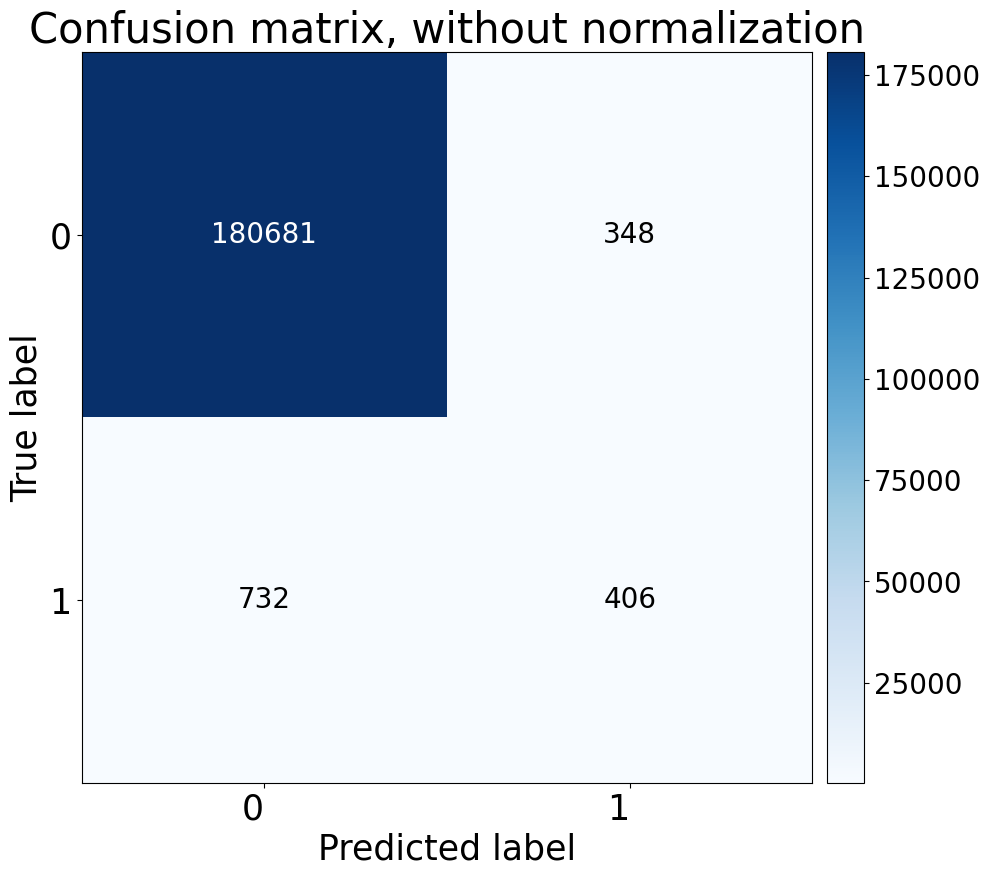

In [15]:
plot_confusion_matrix(
    y_test,
    y_pred,
    np.array(['0', '1']),
)